# Описание данных

Данные состоят из файлов, полученных из разных источников:

- `contract.csv` — информация о договоре;
- `personal.csv` — персональные данные клиента;
- `internet.csv` — информация об интернет-услугах;
- `phone.csv` — информация об услугах телефонии.

Во всех файлах столбец `customerID` содержит код клиента.

Информация о договорах актуальна на 1 февраля 2020.

# Содержание
1. __[Работа с данными](#data_working)__
    * __[Подготовка признаков](#features_extraction)__
    * __[Анализ факторов](#factors_analysis)__
    * __[Формирование финального датасета](#final_datasets)__
    * __[Вывод](#finding_1)__
    
    
2. __[Тренировка моделей](#training_models)__
    * __[Подготовка](#preparation)__
    * __[DummyClassifier](#DummyClassifier)__
    * __[LogisticRegression](#LogisticRegression)__
    * __[SVC](#SVC)__
    * __[LGBMClassifier](#LGBMClassifier)__
    * __[CatBoostClassifier](#CatBoostClassifier)__
    * __[VotingClassifier](#VotingClassifier)__
    * __[Вывод](#finding_2)__ 
    
    
3. __[Тестирование модели](#testing_model)__
    * __[Вывод](#finding_3)__
    
    
4. __[Выводы](#findings)__  

# <a name='data_working'>1. Работа с данными</a>


## <a name='features_extraction'> Подготовка признаков</a>
___

In [2]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier, StackingClassifier
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.preprocessing import  StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.feature_selection import  chi2

from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier, plot_importance

In [3]:
plt.style.use('seaborn-darkgrid')
params = {'axes.titlesize': 18,
      'legend.fontsize': 14,
      'figure.figsize': (15, 6),
      'axes.labelsize': 14,
      'xtick.labelsize': 13,
      'ytick.labelsize': 13,
      'figure.titlesize': 18}
plt.rcParams.update(params)

In [4]:
data_folder = 'data/'
contract = pd.read_csv(data_folder + 'contract.csv', parse_dates=[1], index_col=0)
personal = pd.read_csv(data_folder + 'personal.csv', index_col=0)
internet = pd.read_csv(data_folder + 'internet.csv', index_col=0)
phone = pd.read_csv(data_folder + 'phone.csv', index_col=0)

In [5]:
contract.head()

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
customerID,,,,,,,
7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


In [6]:
personal.head()

,gender,SeniorCitizen,Partner,Dependents
customerID,,,,
7590-VHVEG,Female,0,Yes,No
5575-GNVDE,Male,0,No,No
3668-QPYBK,Male,0,No,No
7795-CFOCW,Male,0,No,No
9237-HQITU,Female,0,No,No


In [7]:
internet.head()

,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
customerID,,,,,,,
7590-VHVEG,DSL,No,Yes,No,No,No,No
5575-GNVDE,DSL,Yes,No,Yes,No,No,No
3668-QPYBK,DSL,Yes,Yes,No,No,No,No
7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
9237-HQITU,Fiber optic,No,No,No,No,No,No


In [8]:
phone.head()

,MultipleLines
customerID,
5575-GNVDE,No
3668-QPYBK,No
9237-HQITU,No
9305-CDSKC,Yes
1452-KIOVK,Yes


Добавим признаки Internet - Yes в таблицу internet , и Phone - Yes в таблицу phone

In [9]:
internet['Internet'] = 'Yes'
phone['Phone'] = 'Yes'

In [10]:
# Объединими таблицы
all_data = pd.concat((contract, personal), axis=1)
all_data = pd.concat((all_data, internet), axis=1)
all_data = pd.concat((all_data, phone), axis=1)
all_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   BeginDate         7043 non-null   datetime64[ns]
 1   EndDate           7043 non-null   object        
 2   Type              7043 non-null   object        
 3   PaperlessBilling  7043 non-null   object        
 4   PaymentMethod     7043 non-null   object        
 5   MonthlyCharges    7043 non-null   float64       
 6   TotalCharges      7043 non-null   object        
 7   gender            7043 non-null   object        
 8   SeniorCitizen     7043 non-null   int64         
 9   Partner           7043 non-null   object        
 10  Dependents        7043 non-null   object        
 11  InternetService   5517 non-null   object        
 12  OnlineSecurity    5517 non-null   object        
 13  OnlineBackup      5517 non-null   object        
 14  DeviceProtecti

Нам нужно создать дополнительную категорию в InternetService со значением 'No и заполнить пропуски.


In [11]:
all_data.fillna('No', inplace=True)

Проверим количество уникальных значений в столбцах. Что бы случайно не затесался какой то баг

In [12]:
n_unique = all_data.nunique()
n_unique

BeginDate             77
EndDate                5
Type                   3
PaperlessBilling       2
PaymentMethod          4
MonthlyCharges      1585
TotalCharges        6531
gender                 2
SeniorCitizen          2
Partner                2
Dependents             2
InternetService        3
OnlineSecurity         2
OnlineBackup           2
DeviceProtection       2
TechSupport            2
StreamingTV            2
StreamingMovies        2
Internet               2
MultipleLines          2
Phone                  2
dtype: int64

Все в порядке, лишних значений нет

<font color='red'>__Разделим признаки на бинарные, категориальные, и количественные. Будем хранить названия признаков в списках__</font>

In [13]:
bi_cols = []
cat_cols = []
num_cols = []
for column, uniques in n_unique.iloc[3:].iteritems():
    if uniques == 2:
        bi_cols.append(column)
    elif uniques < all_data.shape[0]**0.5:
        cat_cols.append(column)
    else:
        num_cols.append(column)
print('Бинарные признаки')
print(bi_cols)
print()
print('Категориальные признаки')
print(cat_cols)
print()
print('Количественные признаки')
print(num_cols)

Бинарные признаки
['PaperlessBilling', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Internet', 'MultipleLines', 'Phone']

Категориальные признаки
['PaymentMethod', 'InternetService']

Количественные признаки
['MonthlyCharges', 'TotalCharges']


In [14]:
# Проверим на дубликати
all_data.duplicated().sum()

13

In [15]:
# Создадим столбец Gone : 1 - ушел, 0 - не ушел
all_data['Gone'] = (contract['EndDate'] != 'No').astype(int)

# Сменим тип на float в столбце TotalCharges
all_data['TotalCharges'] = pd.to_numeric(contract['TotalCharges']
                                         .apply(lambda x: re.sub('[^\d.]', '', x))
                                        )
# В столюце EndDate да значений No поставим дату выгрузки
all_data['EndDate'] = (contract['EndDate']
                        .str.replace('No', '2020-02-01', regex=False)
                        .astype('datetime64')
                       )
# Разобъём дату начала договора на год, месяц
all_data['BeginYear'] = contract['BeginDate'].dt.year
all_data['BeginMonth'] = contract['BeginDate'].dt.month
# Разобъём дату окончания договора на год, месяц
all_data['EndYear'] = all_data['EndDate'].dt.year
all_data['EndMonth'] = all_data['EndDate'].dt.month
# Добавим признаки DurationMonth и DorationDay - Длительность контракта в месяцах и днях
all_data['DurationDay'] = (all_data['EndDate'] - all_data['BeginDate']).dt.days
all_data['DurationMonth'] = 12 * (all_data['EndYear'] - all_data['BeginYear']) \
    + (all_data['EndMonth'] - all_data['BeginMonth'])

all_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 28 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   BeginDate         7043 non-null   datetime64[ns]
 1   EndDate           7043 non-null   datetime64[ns]
 2   Type              7043 non-null   object        
 3   PaperlessBilling  7043 non-null   object        
 4   PaymentMethod     7043 non-null   object        
 5   MonthlyCharges    7043 non-null   float64       
 6   TotalCharges      7032 non-null   float64       
 7   gender            7043 non-null   object        
 8   SeniorCitizen     7043 non-null   int64         
 9   Partner           7043 non-null   object        
 10  Dependents        7043 non-null   object        
 11  InternetService   7043 non-null   object        
 12  OnlineSecurity    7043 non-null   object        
 13  OnlineBackup      7043 non-null   object        
 14  DeviceProtecti

In [16]:
# Посмотрим на пропуски в столбце TotalCharges
all_data[all_data['TotalCharges'].isna()]

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,...,Internet,MultipleLines,Phone,Gone,BeginYear,BeginMonth,EndYear,EndMonth,DurationDay,DurationMonth
4472-LVYGI,2020-02-01,2020-02-01,Two year,Yes,Bank transfer (automatic),52.55,NaN,Female,0,Yes,...,Yes,No,No,0,2020,2,2020,2,0,0
3115-CZMZD,2020-02-01,2020-02-01,Two year,No,Mailed check,20.25,NaN,Male,0,No,...,No,No,Yes,0,2020,2,2020,2,0,0
5709-LVOEQ,2020-02-01,2020-02-01,Two year,No,Mailed check,80.85,NaN,Female,0,Yes,...,Yes,No,Yes,0,2020,2,2020,2,0,0
4367-NUYAO,2020-02-01,2020-02-01,Two year,No,Mailed check,25.75,NaN,Male,0,Yes,...,No,Yes,Yes,0,2020,2,2020,2,0,0
1371-DWPAZ,2020-02-01,2020-02-01,Two year,No,Credit card (automatic),56.05,NaN,Female,0,Yes,...,Yes,No,No,0,2020,2,2020,2,0,0
7644-OMVMY,2020-02-01,2020-02-01,Two year,No,Mailed check,19.85,NaN,Male,0,Yes,...,No,No,Yes,0,2020,2,2020,2,0,0
3213-VVOLG,2020-02-01,2020-02-01,Two year,No,Mailed check,25.35,NaN,Male,0,Yes,...,No,Yes,Yes,0,2020,2,2020,2,0,0
2520-SGTTA,2020-02-01,2020-02-01,Two year,No,Mailed check,20.00,NaN,Female,0,Yes,...,No,No,Yes,0,2020,2,2020,2,0,0
2923-ARZLG,2020-02-01,2020-02-01,One year,Yes,Mailed check,19.70,NaN,Male,0,Yes,...,No,No,Yes,0,2020,2,2020,2,0,0
4075-WKNIU,2020-02-01,2020-02-01,Two year,No,Mailed check,73.35,NaN,Female,0,Yes,...,Yes,Yes,Yes,0,2020,2,2020,2,0,0


Т.к. Данне актуальны на 2020-02-01, то новых пользователей можно будет удалить.

In [17]:
all_data = all_data[all_data['TotalCharges'].notna()]
all_data.reset_index(inplace=True, drop=True)

## <a name='factors_analysis'>Анализ факторов</a>

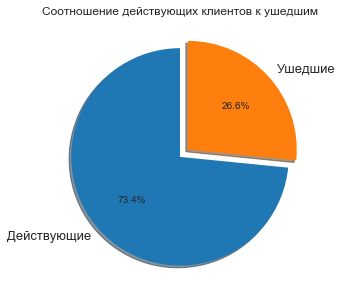

In [18]:
labels = ['Действующие', 'Ушедшие']
sizes = [(all_data['Gone']==0).sum(), all_data['Gone'].sum()]
explode = (0, 0.1)
plt.figure(figsize=(7, 5))
plt.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
plt.title("Соотношение действующих клиентов к ушедшим", size = 12)
plt.show()

Виден дисбаланс. Возможно попробовать применить upsampling либо class weight

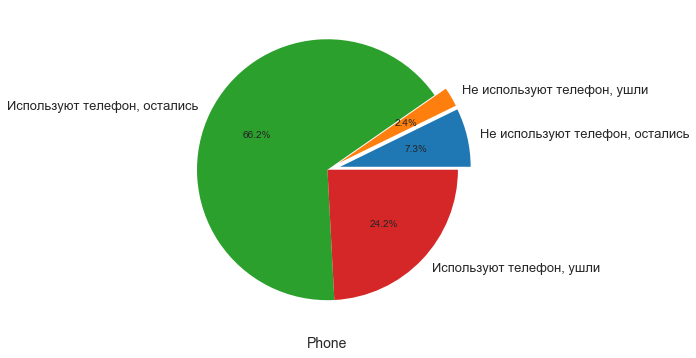

In [19]:
phone_users = all_data.groupby(['Phone', 'Gone'])['gender'].count()
labels = ['Не используют телефон, остались', 'Не используют телефон, ушли', 
          'Используют телефон, остались', 'Используют телефон, ушли', 
         ]
ax = phone_users.plot.pie(labels=labels, autopct='%1.1f%%', explode=(0.1, .1, 0.0, 0.0))
ax.set_ylabel(None);
ax.set_xlabel('Phone');

Видно что каждый чертверный пользователь уходит

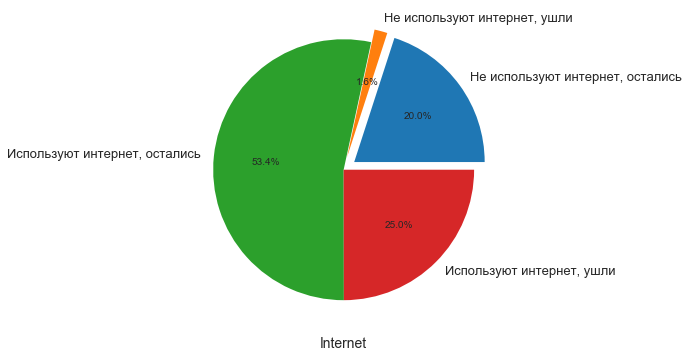

In [20]:
internet_users = all_data.groupby(['Internet', 'Gone'])['gender'].count()
labels = ['Не используют интернет, остались', 'Не используют интернет, ушли', 
          'Используют интернет, остались', 'Используют интернет, ушли', 
         ]
ax = internet_users.plot.pie(labels=labels, autopct='%1.1f%%', explode=(0.1, .1, 0.0, 0.0))
ax.set_ylabel(None);
ax.set_xlabel('Internet');

А вот тут видно, что уходит каждый третий кто пользуется интернетом

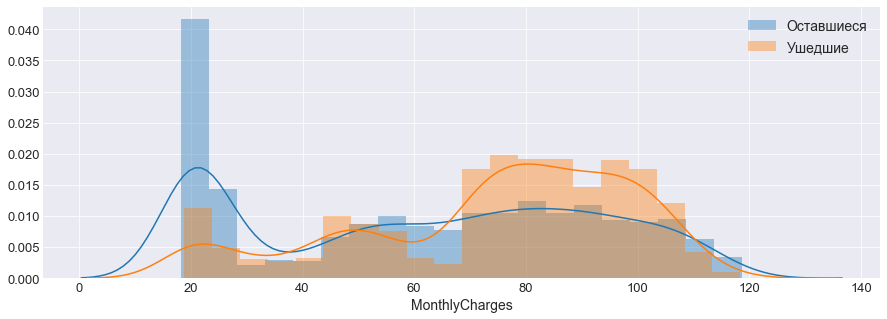

In [21]:
plt.figure(figsize=(15, 5))
sns.distplot(all_data[all_data['Gone']==0]['MonthlyCharges'], bins=20, label='Оставшиеся')
sns.distplot(all_data[all_data['Gone']==1]['MonthlyCharges'], bins=20, label='Ушедшие')
plt.legend();

Из гистограммы видно, что ушедшие платили больше. Так гистограмма ушедших выглядит бимодально возможно есть влияние еще какого то признака.

Посмотрим как уходят клиенты

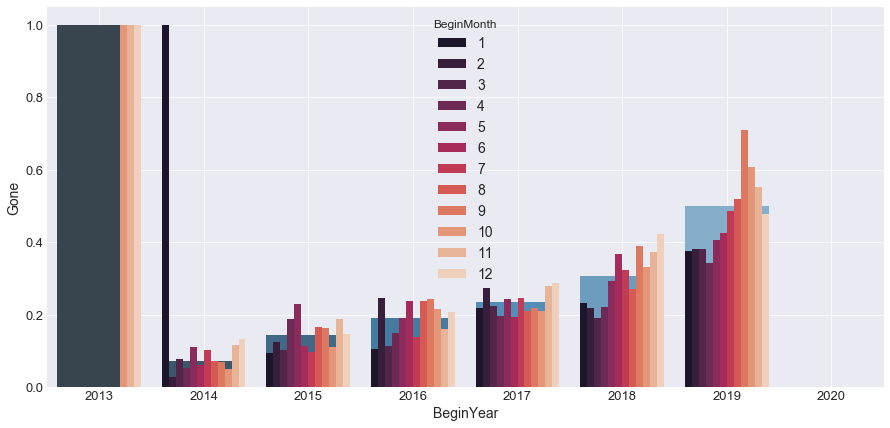

In [22]:
plt.figure(figsize=(15, 7))
sns.barplot(x='BeginYear', 
            y='Gone', 
            data=all_data, 
            palette="Blues_d",
            ci=None,
            ax=plt.gca())

sns.barplot(x='BeginYear', 
            y='Gone', 
            hue='BeginMonth',
            data=all_data, 
            ci=None,
            palette="rocket", 
            ax=plt.gca())
plt.grid(True)

Есть аномалия - все клиенты подключившиеся в 2013 году и в певом месяце 2014 года ушли. Возможно это ошибка в данных либо просто такие данные

Наблюдается увеличение процента оттока клиентов. В 2019 около половины пришедших клиентов уходит. Получается, что чем клиент "Моложе" тем более вероятно он уходит.


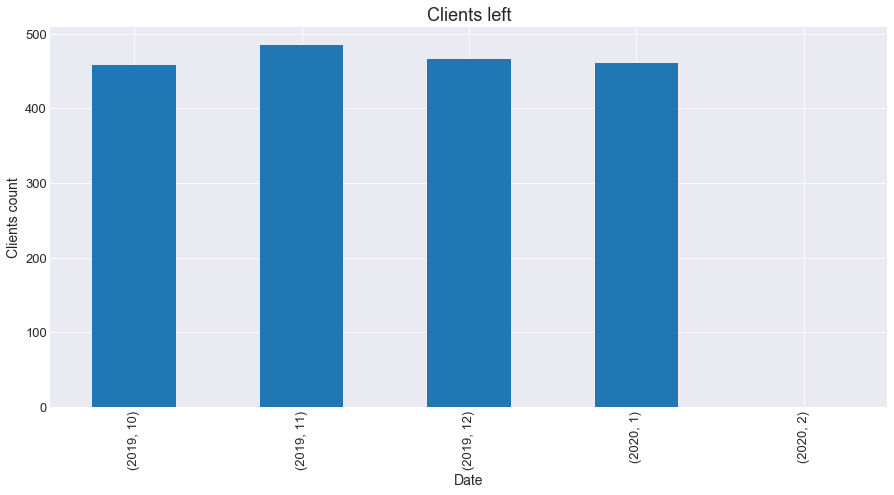

In [23]:
plt.figure(figsize=(15, 7))
all_data.groupby(['EndYear', 'EndMonth']).sum()['Gone'].plot(kind='bar')
plt.title('Clients left')
plt.xlabel('Date')
plt.ylabel('Clients count')
plt.grid(True, axis='y')

Ушедшие клиенты распределились равномерно. Отток начался с октября 2019 года. Скорее всего данные сентетические, 
т.к. маловероятно, что за 6 лет никто не ушел, а под конец 7-го года начался отток. Даже если компания была монополистом, 
то все равно люди могут переезжать, _умирать,_ просто перестать пользоваться и другие причины.

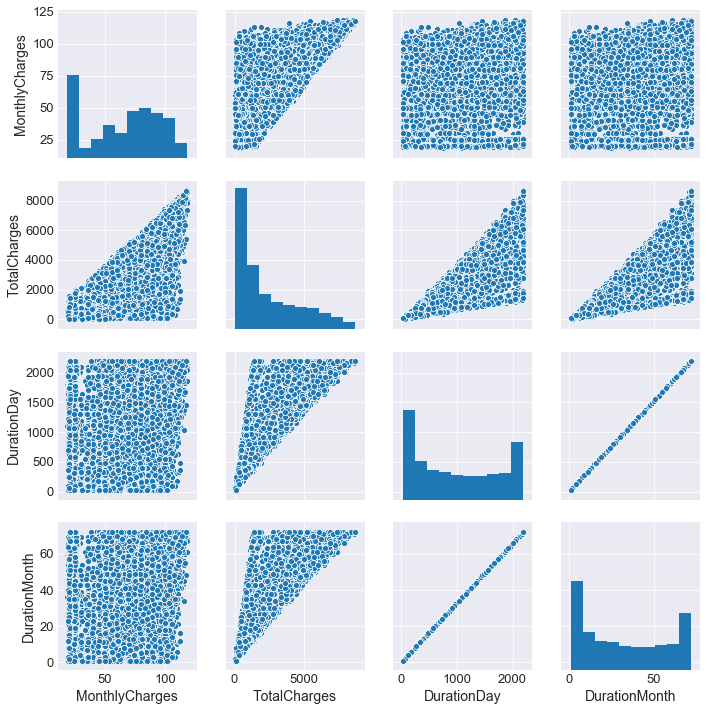

In [24]:
# Посмотрим на количественные признаки
num_data = all_data[num_cols + ['DurationDay'] + ['DurationMonth']]
sns.pairplot(num_data,  diag_kind='hist');

In [25]:
num_data.corr()

,MonthlyCharges,TotalCharges,DurationDay,DurationMonth
MonthlyCharges,1.000000,0.651065,0.246715,0.246862
TotalCharges,0.651065,1.000000,0.825811,0.825880
DurationDay,0.246715,0.825811,1.000000,0.999999
DurationMonth,0.246862,0.825880,0.999999,1.000000


Надо решить какой из признаков оставлять DurationDay или DurationMonth. 
Так же есть сильная корреляция с признаком TotalCharges, что тоже не очень хорошо

Проверим количественные признаки на наличие утечки

In [26]:
def leak_check(data: pd.DataFrame, col: str, target:str):
    """
    Находит уникальные значения в количественных признаках для каждого лейбла.
    Считает какой процент выборки принадлежит 
    каждому уникальному значению признака
    :param data: (pd.DataFrame) Датасет
    :param col: (str) Имя количественного признака
    :param target: (str) Имя целевого признака
    """
    true_data = all_data[all_data[target]==1]
    false_data = data[data[target]==0]
    
    true_count = true_data.shape[0]
    sns.set_palette("rainbow")
    true_val = true_data[col].unique()
    false_val = false_data[col].unique()

    true_unique = list(set(true_val) - set(false_val))
    if len(true_unique): 
        true_unique_count = true_data[col].value_counts()[true_unique].sort_values()
        top_values = round(true_unique_count.iloc[-10:] / true_count * 100, 2)
        top_values.plot(kind='barh', title='Top 10 unique values',
                        figsize=(15, 5))
        plt.xlabel('Target percentage')
        plt.ylabel('Unique value')
        print('Суммарный процент ТОП 10:', top_values.sum())
    else:
        print('Уникальных значений нет')

Суммарный процент ТОП 10: 1.91


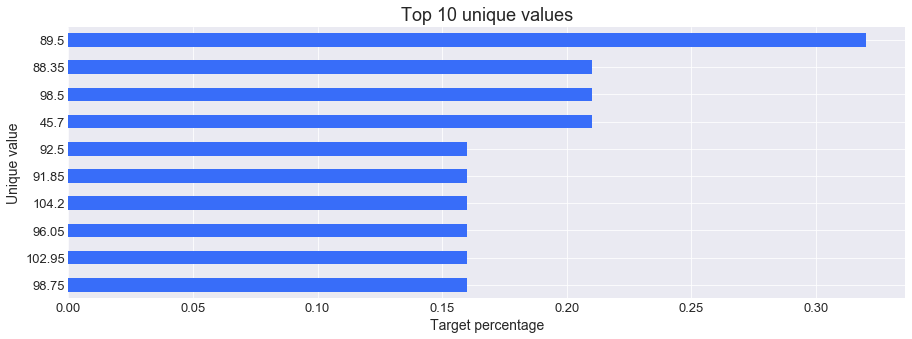

In [27]:
# Проверим количественные признаки на наличие утечек
leak_check(all_data, 'MonthlyCharges', 'Gone')

In [28]:
leak_check(all_data, 'DurationMonth', 'Gone')

Уникальных значений нет


Суммарный процент ТОП 10: 30.65


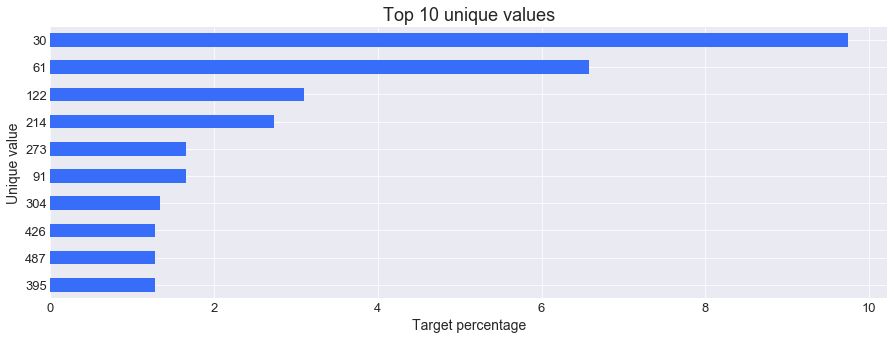

In [29]:
leak_check(all_data, 'DurationDay', 'Gone')

DurationDay - утечка

Итого добавим только столбец DurationMonth

In [30]:
num_cols.append('DurationMonth')

Попробуем выделить новые признаки при помощи кластеризации 

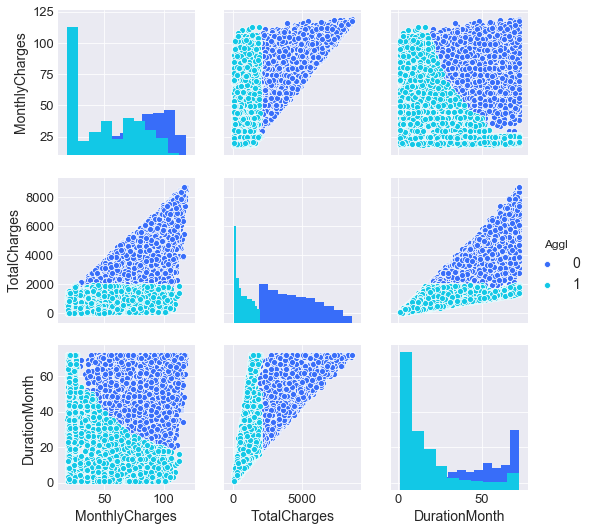

In [31]:
num_data = all_data.loc[:,num_cols]
claster_model = AgglomerativeClustering()
claster_model.fit(num_data)

# Добавление столбца с номером кластера
num_data['Aggl'] = claster_model.labels_.astype(str)

# Построение графика
sns.pairplot(num_data, vars=num_data.columns[:-1], hue='Aggl', diag_kind='hist');

In [32]:
all_data['Aggl'] = num_data['Aggl'].astype(float)
bi_cols.append('Aggl')

Еще я бы хотел попробовать разбить признак MonthlyCharges на три категории.

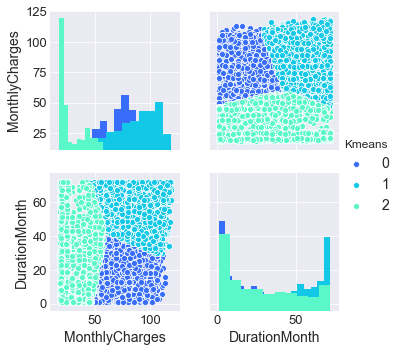

In [33]:
num_data = all_data.loc[:, ['MonthlyCharges', 'DurationMonth']]
claster_model = KMeans(n_clusters=3, random_state=42)

claster_model.fit(num_data)

# Добавление столбца с номером кластера
num_data['Kmeans'] = claster_model.labels_.astype(str)

# Построение графика
sns.pairplot(num_data, vars=num_data.columns[:-1], hue='Kmeans', diag_kind='hist');

In [34]:
all_data['Kmeans'] = num_data['Kmeans'].astype(float)
cat_cols.append('Kmeans')

## <a name='final_datasets'>Формирование финального датасета</a>

Сформируем финальный датасет, с которым будем работать

В дальнейшем мы будем пробовать модели как линейные так и сложные вроде бустина и нейронных сетей. Для линейных моделей и нейронных сетей хорошо подойдёт OneHotEncoder. Для бустинга лучше использовать OrdinalEncoder. Т.к. в итоге планируется собрать ансамбль из моделей, то будет выбран метод OneHotEncoder

In [35]:
ohe_encoder = OneHotEncoder(categories='auto', drop='first', sparse=False)
features_ohe = ohe_encoder.fit_transform(all_data[cat_cols + bi_cols])
features_ohe = pd.DataFrame(features_ohe, columns=ohe_encoder.get_feature_names(cat_cols + bi_cols))
features_ohe.shape

(7032, 22)

И так сразу отбросим лишние признаки будем использовать Хи квадрат пирсона

In [36]:
p_values = chi2(features_ohe, all_data['Gone'])[1]
sorted(zip(ohe_encoder.get_feature_names(cat_cols + bi_cols), p_values), key=lambda x: x[1], reverse=True)

[('Phone_Yes', 0.7604618273699781),
 ('gender_Male', 0.6140655052865054),
 ('MultipleLines_Yes', 0.010698929466188598),
 ('StreamingMovies_Yes', 6.570739220869369e-05),
 ('StreamingTV_Yes', 3.1574292822260756e-05),
 ('DeviceProtection_Yes', 6.917170629742512e-06),
 ('OnlineBackup_Yes', 2.3159018157251026e-08),
 ('PaymentMethod_Mailed check', 2.2672702959413508e-11),
 ('Aggl_1.0', 3.0743565395792166e-16),
 ('Internet_Yes', 7.14518162547137e-19),
 ('Partner_Yes', 1.4624091492682525e-19),
 ('PaymentMethod_Credit card (automatic)', 1.5452481952118027e-23),
 ('PaperlessBilling_Yes', 1.2342317320100526e-24),
 ('Dependents_Yes', 2.159539604878587e-30),
 ('SeniorCitizen_1', 7.089546081646486e-31),
 ('TechSupport_Yes', 2.645952202437101e-31),
 ('Kmeans_1.0', 1.2432357644053974e-31),
 ('OnlineSecurity_Yes', 7.219882528593977e-34),
 ('Kmeans_2.0', 2.13116498676908e-37),
 ('InternetService_No', 4.8139995100107706e-64),
 ('InternetService_Fiber optic', 6.587130449296343e-83),
 ('PaymentMethod_Elect

Я бы выкинул столбцы, у которых p_value > 0.05

In [37]:
features_ohe.drop(['Phone_Yes', 'gender_Male'], axis=1, inplace=True)

In [38]:
num_data = pd.DataFrame(np.log(all_data.loc[:,num_cols]), columns=num_cols)
features_ohe = pd.concat((features_ohe, num_data), axis=1)
features_ohe = pd.concat((features_ohe, all_data[['Gone']]), axis=1)

Поделим выборки на тренировочную и тестовую

In [39]:
train_data, test_data = train_test_split(features_ohe, 
                                   train_size=.75,
                                   shuffle=True,
                                   stratify=features_ohe['Gone'],
                                   random_state=42
                                  )
train_data.shape, test_data.shape

((5274, 24), (1758, 24))

Стандартизируем количественные признаки

In [40]:
scaler = StandardScaler()
train_data.loc[:, num_cols] = scaler.fit_transform(train_data.loc[:, num_cols])
test_data.loc[:, num_cols] = scaler.transform(test_data.loc[:, num_cols])

c:\users\svetl\for project\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
c:\users\svetl\for project\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [42]:
train_data.head()

,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,InternetService_Fiber optic,InternetService_No,Kmeans_1.0,Kmeans_2.0,PaperlessBilling_Yes,SeniorCitizen_1,Partner_Yes,...,TechSupport_Yes,StreamingTV_Yes,StreamingMovies_Yes,Internet_Yes,MultipleLines_Yes,Aggl_1.0,MonthlyCharges,TotalCharges,DurationMonth,Gone
3681,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,1.0,1.0,0.0,1.0,0.977016,0.384558,0.016048,1
5544,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,1.0,-0.006774,-1.882437,-2.209655,1
6859,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.484391,0.820733,0.732175,0
1869,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,1.0,1.0,1.0,1.0,1.0,0.0,0.732235,0.795003,0.633439,0
147,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,-0.341282,-2.010452,-2.209655,1


## <a name='finding_1'>Вывод:</a>
1. Обработали данные: 
    * соединили таблицы
    * добавили признаки 
        * `Internet` 1 - Yes, - No 
        * `DurationMonth` продолжительность сотрудничества в месяцах
        * `Aggl` - Признаки полученные при помощи кластеризации AgglomerativeClustering
        * `Kmeans` - Признаки полученные при помощи кластеризации KMeans
    * Удалили Новых пользователей, которые подключились 2020-02-01
2. Провели анализ факторов:
    * Для категорий использовали OneHotEncoder
3. Подготовили данные для дальнейшего использования в моделях.
    * Количественные признаки стандартизированы
    * Данные разбиты на тренировочную и тестовую выборки 75:25

# <a name='training_models'>2. Тренировка моделей</a>

## <a name='preparation'>Подготовка</a>

In [43]:
def find_parameters(estimator: object, parameters: dict, data: pd.DataFrame) -> pd.DataFrame:
    """
    Подбирает лучшие гиперпараметры и обучает с ними estimator
    :param estimator: (object) sklearn estimator 
    :param parameters: (dict) cловарь {Параметр: [значеня],...}
    :param data: (pd.DataFrame) данные для тренировки, где послезний столбец - целевой признак
    :return:
        results: (pd.DataFrame) значения метрик
    """
    X, y = data.iloc[:, :-1], data.iloc[:, -1]
    gscv = GridSearchCV(estimator, parameters,
                        scoring=('roc_auc', 'precision', 'recall', 'accuracy'), 
                        n_jobs=-1, cv=3, refit='roc_auc')
    gscv.fit(X, y)
    best_index = np.argmax(gscv.cv_results_['mean_test_roc_auc'])
    
    results = pd.DataFrame.from_dict({
        'roc_auc': [gscv.cv_results_['mean_test_roc_auc'][best_index]],
        'precision': [gscv.cv_results_['mean_test_precision'][best_index]],
        'recall': [gscv.cv_results_['mean_test_recall'][best_index]],
        'accuracy': [gscv.cv_results_['mean_test_accuracy'][best_index]]}
    )
    
    print(gscv.cv_results_['params'][best_index])
    estimator.set_params(**gscv.best_params_)
    estimator.fit(X, y)
    return results

## <a name='DummyClassifier'>DummyClassifier</a>

In [44]:
%%time
dummy_model = DummyClassifier(random_state=42)
params = {'strategy': ['stratified', 'most_frequent', 'prior', 'uniform']}
find_parameters(dummy_model, params, train_data)

{'strategy': 'stratified'}
Wall time: 1.99 s


,roc_auc,precision,recall,accuracy
0,0.501928,0.268678,0.266771,0.612059


## <a name='LogisticRegression'>LogisticRegression</a>

In [44]:
%%time
logreg_model = LogisticRegression(random_state=42, n_jobs=-1, 
                                  max_iter=200, penalty='l2')
params = {'C': np.linspace(0.1, 1., 10),
          'solver': ['newton-cg', 'lbfgs', 'sag', 'saga'],
          'class_weight': ['balanced', None]
         }
find_parameters(logreg_model, params, train_data)

{'C': 0.5, 'class_weight': None, 'solver': 'saga'}
Wall time: 5.71 s


,roc_auc,precision,recall,accuracy
0,0.842761,0.682435,0.506438,0.80565


In [45]:
# Посмотрим на коэффициенты. 
# Т.к. нам важна величина, то возьмем абсолютные значения
coeff_impotance = np.abs(logreg_model.coef_[0])

feature_impotance = pd.DataFrame(zip(train_data.columns[:-1], coeff_impotance),
                                 columns=['Features', 'Impotance'])

feature_impotance.sort_values('Impotance', ascending=False).head(10)

,Features,Impotance
3,InternetService_Fiber optic,1.321157
4,InternetService_No,0.955989
17,Internet_Yes,0.953166
22,DurationMonth,0.670617
18,MultipleLines_Yes,0.465262
14,TechSupport_Yes,0.437030
15,StreamingTV_Yes,0.433750
11,OnlineSecurity_Yes,0.403257
1,PaymentMethod_Electronic check,0.401560
7,PaperlessBilling_Yes,0.381497


## <a name='SVC'>SVC</a>

In [46]:
%%time
svc_model = SVC(random_state=42, probability=True)
params = {'C': np.linspace(0.1, 1., 10),
          'class_weight': ['balanced', None],
          'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
          'gamma': ['scale', 'auto']
         }
find_parameters(svc_model, params, train_data)

{'C': 0.1, 'class_weight': 'balanced', 'gamma': 'scale', 'kernel': 'linear'}
Wall time: 3min 52s


,roc_auc,precision,recall,accuracy
0,0.841803,0.538886,0.767462,0.763557


In [47]:
# Посмотрим на коэффициенты. 
# Т.к. нам важна величина, то возьмем абсолютные значения
coeff_impotance = np.abs(svc_model.coef_[0])

feature_impotance = pd.DataFrame(zip(train_data.columns[:-1], coeff_impotance),
                                 columns=['Features', 'Impotance'])

feature_impotance.sort_values('Impotance', ascending=False).head(10)

,Features,Impotance
3,InternetService_Fiber optic,0.854940
17,Internet_Yes,0.612477
4,InternetService_No,0.612477
1,PaymentMethod_Electronic check,0.439495
11,OnlineSecurity_Yes,0.439076
14,TechSupport_Yes,0.425769
22,DurationMonth,0.370842
5,Kmeans_1.0,0.351336
21,TotalCharges,0.305458
7,PaperlessBilling_Yes,0.294183


## <a name='LGBMClassifier'>LGBMClassifier</a>

In [48]:
%%time
lgb_model = LGBMClassifier(class_weight='balanced', random_state=42, n_jobs=-1)
params = {'num_leaves': np.arange(2, 11, 2),
          'learning_rate': np.linspace(0.01, 0.5, 4),
          'n_estimators': np.arange(20, 101, 20),
          'reg_alpha': np.linspace(0.1, 1, 4),
          'reg_lambda': np.linspace(0.1, 1, 4),
          'class_weight': ['balanced', None]
         }

find_parameters(lgb_model, params, train_data)

{'class_weight': None, 'learning_rate': 0.33666666666666667, 'n_estimators': 100, 'num_leaves': 2, 'reg_alpha': 0.7, 'reg_lambda': 0.4}
Wall time: 2min 54s


,roc_auc,precision,recall,accuracy
0,0.84475,0.681521,0.507862,0.805271


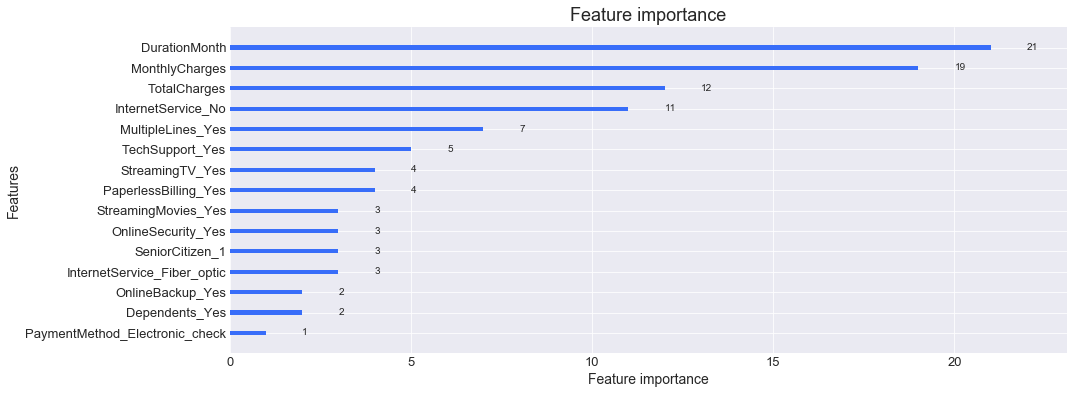

In [49]:
plot_importance(lgb_model)

## <a name='CatBoostClassifier'>CatBoostClassifier</a>

In [50]:
%%time
catboost_model = CatBoostClassifier(random_seed=42, verbose=0)
params = {'iterations': [2000, 3000],
          'learning_rate': [5e-4, 1e-3],
          'bootstrap_type': ['Bayesian', 'Bernoulli'],
          'auto_class_weights': ['Balanced', 'SqrtBalanced']
         }
find_parameters(catboost_model, params, train_data)

{'auto_class_weights': 'Balanced', 'bootstrap_type': 'Bernoulli', 'iterations': 3000, 'learning_rate': 0.001}
Wall time: 14min 49s


,roc_auc,precision,recall,accuracy
0,0.840748,0.530607,0.751781,0.75711


In [51]:
catboost_model.get_feature_importance(prettified=True).head(10)

,Feature Id,Importances
0,DurationMonth,27.501561
1,InternetService_Fiber optic,15.114434
2,TotalCharges,8.525300
3,MonthlyCharges,7.368185
4,Internet_Yes,7.307119
5,PaymentMethod_Electronic check,5.374023
6,OnlineSecurity_Yes,3.789128
7,TechSupport_Yes,3.666307
8,PaperlessBilling_Yes,3.348752
9,MultipleLines_Yes,2.903281


## <a name='VotingClassifier'>VotingClassifier</a>

In [52]:
estimators = [('lr', logreg_model), ('svc', svc_model),
              ('lgb', lgb_model), ('cb', catboost_model)]

In [53]:
voting_model = VotingClassifier(estimators, n_jobs=-1)
params = {'voting': ['soft']}
find_parameters(voting_model, params, train_data)

{'voting': 'soft'}


,roc_auc,precision,recall,accuracy
0,0.844425,0.654718,0.573472,0.80584


## <a name='finding_2'>Вывод:</a>
1. Модели показали следующие значения метрик  

model | roc-auc | precision | recall | accuracy |
------|---------|-----------|--------|----------|
LogisticRegression | 0.842761 | 0.682435 | 0.506438 | 0.80565 | 
SVC | 0.841803 | 0.538886 | 0.767462 | 0.763557 |
LGBMClassifier | 0.84475 | 0.681521 | 0.507862 | 0.805271 |
CatBoostClassifier | 0.840748 | 0.530607 | 0.751781 | 0.75711 |
VotingClassifier | 0.844425 | 0.654718 | 0.573472 | 0.80584 |

2. Возможно следует попробовать применить OrdinalEncoder для категориальных признаков и попробовать добавить в GridSearch еще параметров для Бустингов.
3. В целом значения целевой метрики рядом и логично использовать ту модель каторая имеет прирост в скорости и высокий precision или recall. Тут важно уточнить что для бизнеса важнее.
4. Сейчас как итоговую модель возьмем ансамбль из всех натренированных моделей. 
5. По поводу признаков. Длительность жизни клиента попала в топ 10 во всех моделях. В остальном не наблюдаются какие признаки. 

__Возможные пути увеличения целевой метрики__
1. Использовать OrdinalEncoder для категориальных признаков. И добавить больше параметров в бустинги для поиска.
2. Отфильтровать признаки по важности на линейных моделях с помощью SequentialFeatureSelector.
3. Попробовать нейронные сети, начиная с глупых если они дадут прирост лучше линейных моделей, то продолжать развивать сеть.

#  <a name='testing_model'>3. Тестирование модели</a>

In [54]:
predictions = voting_model.predict_proba(test_data.iloc[:,:-1])[:, 1]
print(f'Значение ROC_AUC на тестовой выборке: {roc_auc_score(test_data.iloc[:,-1], predictions):.4}')
print(f'Значение accuracy на тестовой выборке: {accuracy_score(test_data.iloc[:,-1], np.rint(predictions)):.4}')

Значение ROC_AUC на тестовой выборке: 0.8422
Значение accuracy на тестовой выборке: 0.8009


## <a name='finding_1'>Вывод:</a>
1. Значение accuracy на тестовой выборке получилось 0.8009
2. Значение roc-auc - 0.8422
3. В результате эффективно работаю линейние модели, такие как LogisticRegression, LinearSVC

# <a name='findings'>Выводы:</a>
1. Обработали данные: 
    * соединили таблицы
    * добавили признаки 
        * `Internet` 1 - Yes, - No 
        * `DurationMonth` продолжительность сотрудничества в месяцах
        * `Aggl` - Признаки полученные при помощи кластеризации AgglomerativeClustering
        * `Kmeans` - Признаки полученные при помощи кластеризации KMeans
    * Поменяли типы данных в TotalCharges, MonthlyCharges
    * Удалили Новых пользователей, которые подключились 2020-02-01
2. Провели анализ факторов:
    * Столбцы genre, Phone - были удалены
3. Подготовили данные для дальнейшего использования в моделях.
    * Количественные признаки стандартизированы
    * Данные разбиты на тренировочную и тестовую выборки 75:25
4. Натренировали модели LinearRegression, LGBMClassifier, CatBoostClassifier.
5. Создали на основе этих моделей ансамбль VotingClassifier
6. Значение accuracy на тестовой выборке получилось 0.8009
7. Значение roc-auc - 0.822